# Proyecto Inteligencia Computacional - Proyecto 8 - ID 8a

## Integrantes
- Juan Pablo Contreras
- Pascual Marcone

## Ayudante
- Sebastian Guzman

# Dependencias

In [1]:
#libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

#system
from pathlib import Path
import time

#ai
import torch
from torch import nn
import torchvision
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import src
importlib.reload(src)

<module 'src' (namespace) from ['c:\\Users\\pmarc\\Universidad\\inteli\\ZTF_alert_8a\\src']>

# Data access

In [2]:
#load everything
stamps_dataset = pd.read_pickle('data/5stamps_dataset.pkl')
dataset_1_21 = pd.read_pickle('data/stamp_dataset_21_new.pkl')
dataset_2_28 = pd.read_pickle('data/stamp_dataset_28.pkl')
dataset_2_45 = pd.read_pickle('data/stamp_dataset_45.pkl')
dataset_1_45 = pd.read_pickle('data/stamp_dataset_jun_allwise_45_final.pkl')
dataset_2_63 = pd.read_pickle('data/stamp_dataset_only_images_63.pkl')
dataset_1_63 = pd.read_pickle('data/td_ztf_stamp_17_06_20.pkl')

In [ ]:
#changing all labels to match for ease of use in the future
def rename_labels(dataset, old_value, new_value):
    for key in dataset.keys():
        if old_value in dataset[key]:
            dataset[key][new_value] = dataset[key].pop(old_value)

# apply the function to 
rename_labels(stamps_dataset, 'labels', 'class')
rename_labels(dataset_1_63, 'labels', 'class')
rename_labels(stamps_dataset, 'science', 'images')

## Data Characterization

In [68]:
from anytree import Node, RenderTree

# stamps_dataset
root = Node(f"stamps_dataset -- {stamps_dataset['Train']['images'].shape}")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("labels", parent=train)
images = Node("images", parent=train)
template = Node("template", parent=train)
difference = Node("difference", parent=train)

s_labels = Node("labels", parent=validation)
s_images = Node("images", parent=validation)
s_template = Node("template", parent=validation)
s_difference = Node("difference", parent=validation)

t_labels = Node("labels", parent=test)
t_images = Node("images", parent=test)
t_template = Node("template", parent=test)
t_difference = Node("difference", parent=test)

# Render the tree
for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

# dataset_1_21
root = Node(f"dataset_1_21 -- {dataset_1_21['Train']['images'].shape}")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("images", parent=train)
images = Node("features", parent=train)
template = Node("oid", parent=train)
difference = Node("class", parent=train)

s_labels = Node("images", parent=validation)
s_images = Node("features", parent=validation)
s_template = Node("oid", parent=validation)
s_difference = Node("class", parent=validation)

t_labels = Node("images", parent=test)
t_images = Node("features", parent=test)
t_template = Node("oid", parent=test)
t_difference = Node("class", parent=test)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

# dataset_2_28
root = Node(f"dataset_2_28 -- {dataset_2_28['Train']['images'].shape}")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("images", parent=train)
images = Node("features", parent=train)
template = Node("oid", parent=train)
difference = Node("class", parent=train)

s_labels = Node("images", parent=validation)
s_images = Node("features", parent=validation)
s_template = Node("oid", parent=validation)
s_difference = Node("class", parent=validation)

t_labels = Node("images", parent=test)
t_images = Node("features", parent=test)
t_template = Node("oid", parent=test)
t_difference = Node("class", parent=test)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

# dataset_2_45
root = Node(f"dataset_2_45 -- {dataset_2_45['Train']['images'].shape}")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("images", parent=train)
images = Node("features", parent=train)
template = Node("oid", parent=train)
difference = Node("class", parent=train)

s_labels = Node("images", parent=validation)
s_images = Node("features", parent=validation)
s_template = Node("oid", parent=validation)
s_difference = Node("class", parent=validation)

t_labels = Node("images", parent=test)
t_images = Node("features", parent=test)
t_template = Node("oid", parent=test)
t_difference = Node("class", parent=test)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

# dataset_1_45
root = Node(f"dataset_1_45 -- {dataset_1_45['Train']['images'].shape}")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("images", parent=train)
images = Node("features", parent=train)
template = Node("oid", parent=train)
difference = Node("class", parent=train)

s_labels = Node("images", parent=validation)
s_images = Node("features", parent=validation)
s_template = Node("oid", parent=validation)
s_difference = Node("class", parent=validation)

t_labels = Node("images", parent=test)
t_images = Node("features", parent=test)
t_template = Node("oid", parent=test)
t_difference = Node("class", parent=test)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

# dataset_2_63
root = Node(f"dataset_2_63 -- {dataset_2_63['Train']['images'].shape}")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("images", parent=train)
difference = Node("class", parent=train)

s_labels = Node("images", parent=validation)
s_difference = Node("class", parent=validation)

t_labels = Node("images", parent=test)
t_difference = Node("class", parent=test)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

# dataset_1_63
root = Node(f"dataset_1_63 -- {dataset_1_63['Train']['images'].shape}")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("images", parent=train)
images = Node("features", parent=train)
difference = Node("labels", parent=train)

s_labels = Node("images", parent=validation)
s_images = Node("features", parent=validation)
s_difference = Node("labels", parent=validation)

t_labels = Node("images", parent=test)
t_images = Node("features", parent=test)
t_difference = Node("labels", parent=test)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))

stamps_dataset -- (123227, 5, 21, 21)
├── Train
│   ├── labels
│   ├── images
│   ├── template
│   └── difference
├── validation
│   ├── labels
│   ├── images
│   ├── template
│   └── difference
└── Test
    ├── labels
    ├── images
    ├── template
    └── difference


dataset_1_21 -- (72710, 21, 21, 3)
├── Train
│   ├── images
│   ├── features
│   ├── oid
│   └── class
├── validation
│   ├── images
│   ├── features
│   ├── oid
│   └── class
└── Test
    ├── images
    ├── features
    ├── oid
    └── class


dataset_2_28 -- (50594, 28, 28, 3)
├── Train
│   ├── images
│   ├── features
│   ├── oid
│   └── class
├── validation
│   ├── images
│   ├── features
│   ├── oid
│   └── class
└── Test
    ├── images
    ├── features
    ├── oid
    └── class


dataset_2_45 -- (50594, 45, 45, 3)
├── Train
│   ├── images
│   ├── features
│   ├── oid
│   └── class
├── validation
│   ├── images
│   ├── features
│   ├── oid
│   └── class
└── Test
    ├── images
    ├── features
    ├── oid
    └── c

# Visualizacion Datos
Hay 3 tipos de imagenes $21\cdot21$, $28\cdot28$, $45\cdot45$ y $63\cdot63$

In [179]:
print(np.unique(stamps_dataset['Train']['class']))
print(np.unique(dataset_1_21['Train']['class']))
print(np.unique(dataset_1_45['Train']['class']))
print(np.unique(dataset_1_63['Train']['class']))
print(np.unique(dataset_2_28['Train']['class']))
print(np.unique(dataset_2_45['Train']['class']))
print(np.unique(dataset_2_63['Train']['class']))

[0. 1. 2.]
[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
[0 1 2 3 4]
['AGN' 'SN' 'VS' 'asteroid' 'bogus']
['AGN' 'SN' 'VS' 'asteroid' 'bogus']
['AGN' 'SN' 'VS' 'asteroid' 'bogus']


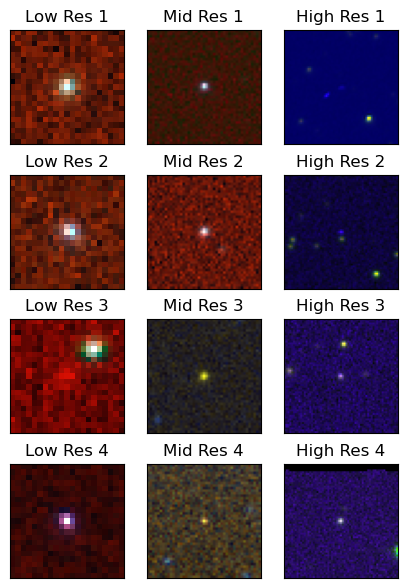

In [148]:
import src.plots as plots
importlib.reload(plots)

plots.plot_example_dataset(dataset_1_21, dataset_1_45, dataset_1_63, n=4)#sample = [0,1,2,3],n=3)

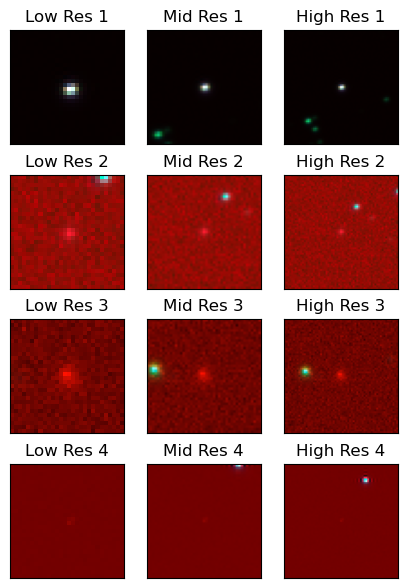

In [157]:
plots.plot_example_dataset(dataset_2_28, dataset_2_45, dataset_2_63,n=4) #sample = [0,1,2,3],n=3)

Analizando algunos ejemplos de cada una

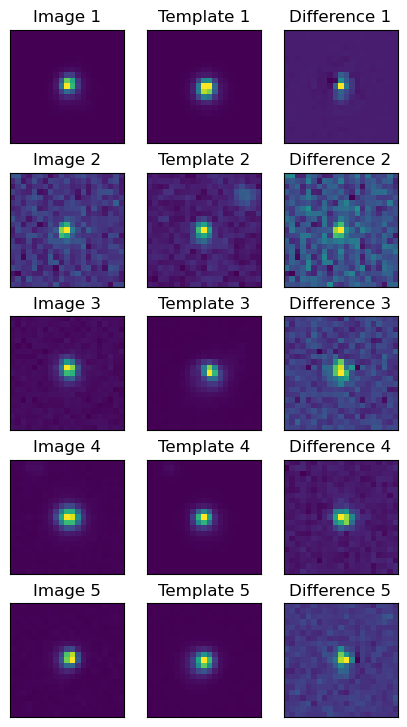

In [158]:
import src.plots as plots
importlib.reload(plots)

plots.plot_example(stamps_dataset, n = 5)

# Creacion de Modelo

In [180]:
class MLPClassifier(nn.Module):
    def __init__(self, n_features, layer_sizes):
        super().__init__()

        # layers = []
        # prev_size = n_features
        # for layer_size in layer_sizes:
        #     layers.append(nn.Linear(prev_size, layer_size))
        #     layers.append(nn.ReLU())
        #     prev_size = layer_size

        # layers.append(nn.Linear(prev_size, 1))
        # layers.append(nn.Sigmoid())

        # self.net = nn.Sequential(*layers)

        #####################################
        #### DEFINIR NUESTRO MODELO AQUI ####
        #####################################

    def forward(self, x):
        return self.net(x)

In [ ]:
model = MLPClassifier() #falta definir los parámetros

# Entrenamiento de Modelo

In [ ]:
import src.model.train as train
importlib.reload(train)

In [ ]:
train.train_model(model) #falta definir los parámetros